In [347]:
import  sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly as ply
import plotly.express as px
import math as ma
import statsmodels as sta
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

In [348]:
bix_sta_prox = pd.read_csv('C:/Users/ckedd/Documents/Capstone data/bix_sta_prox.csv')

In [349]:
bix_sta_prox.drop('Unnamed: 0', axis=1, inplace=True)
bix_sta_prox.head()

,Metro prox count,close stations,Distance from bixi center,Distance from center,points of interest prox count,Rec prox count,public prox count,Cultural prox count,Commercial prox count,pk,name,latitude,longitude,pop_density,number of trips,Mont Royal
0,1.0,8.0,8.193316,21.375417,14.0,6.0,6.0,2.0,0.0,10,Métro Angrignon (Lamont / des Trinitaires),45.446910,-73.603630,0.0,9321.0,0.0
1,0.0,4.0,6.712111,18.941373,7.0,3.0,4.0,0.0,0.0,13,Métro de l'Église (Ross / de l'Église),45.462726,-73.565959,11091.5,17037.0,0.0
2,0.0,7.0,6.429883,14.930417,13.0,11.0,1.0,0.0,1.0,17,Tolhurst / Fleury,45.544149,-73.667520,8987.1,5498.0,0.0
3,1.0,10.0,1.891975,12.761342,10.0,4.0,5.0,1.0,0.0,21,St-Christophe / Cherrier,45.520290,-73.568119,13566.4,9352.0,0.0
4,0.0,2.0,3.719539,10.452843,3.0,2.0,1.0,0.0,0.0,31,Lespérance / de Rouen,45.538839,-73.552779,14720.6,7556.0,0.0


| column | data | 
|---|---|
| close stations | number of other stations within 500m of the target station |
| Distance from bixi center | Distance of the target station from the mean longitude and latitude of all bixi stations |
| Distance from center | Distance of the target station from the "center" of Montreal, "center" defined by googled coordinates of Montreal |
| points of interest prox count | The number of "points of interest" within 500m of the target station |
| Rec prox count | The number of points of interests classified as "Recreational" within 500m of the target station |
| public prox count | The number of points of interests classified as "Public Services" within 500m of the target station |
| Cultural prox count | The number of points of interests classified as "Cultural" within 500m of the target station |
| Commecial prox count | The number of points of interests classified as "Commercial" within 500m of the target station |
| pk* | The identification code for each station *dropped for modelling purposes |
| name* | The given name for each station *dropped for modelling purposes |
| longitude* | The longitude of the target station *dropped for modelling purposes |
| latitude* | The latitude of the target station *dropped for modelling purposes |
| pop_density | The population density for the area surrounding the station |
| Metro prox count | The number of Metro stations within 500m of the bike station |
| number of trips** | the total trips to and from the target station **model target |


In this Notebook, I will be testing my preliminary models, and seeing which data transformations will be required to minimise the Mean Absolute Error. I chose MAE as my main accuracy metric, as it allows for easy analysis on how the MAE could impact results. For instance if a model generates an MAE of 10000, and a large number of the stations have under 10000 MAE, the issues with errors is clear to explain. A second reason for choosing MAE, is that my dataset contains a significant number of outlier data points, which would be magnified if I chose to use a error squared metric.

R^2 score will also be recorded, to compare the slight differences within the models, as well as providing an idea of accuracy on a scale of 1 (perfect accuracy) and 0 (a model that ALWAYS predicts the average y).

For my train_test_splits, I will generate a test dataset, as well as a training and validation dataset. The training and validation dataset need to be separated, in order to optimise the model, without test data being involved. Validation data, will allow for the accuracy of models to be measured, without the models fitting to the test data, which will only be used for the final model in the final notebook. To guarentee that the training, validation and test datasets are the same across all of the models, I am implimenting a random_state. This causes the the same split of data every time, so the models are fairly compared to each other.

In [350]:
from sklearn.model_selection import train_test_split

X = bix_sta_prox.drop(['number of trips', 'pk', 'name', 'longitude', 'latitude'], axis=1)
y = bix_sta_prox['number of trips']

X_CV, X_test, y_CV, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_CV,y_CV, test_size=0.2, random_state=1)

In [351]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
DT_reg_base = DecisionTreeRegressor()

DT_reg_base.fit(X_train, y_train)

print(f"The training score of the inital DecisionTree of the {DT_reg_base.score(X_train, y_train)}")
print(f"The testing score of the initial DecisionTree{DT_reg_base.score(X_valid, y_valid)}")
print(f"The testing score for the inital DecisionTree model using MAE is {mean_absolute_error(y_valid, DT_reg_base.predict(X_valid))}")

The training score of the inital DecisionTree of the 1.0
The testing score of the initial DecisionTree-0.2136584321965389
The testing score for the inital DecisionTree model using MAE is 8871.8828125


This initial Decision Tree model is terrible. Whilst it is perfect at predicting the data points it is terrible when new data is introduced. This is due to massive overfitting, as the there are no limits on the model, it will keep working until it perfectly categorises each training data point. In doing this, the model overcorrects X-variables to match outliers, making the predictive variable unable to predict data that isn't exactly what it was trained on.

To improve this initial model, I will run a GridSearch, which tests each potential hyper-parameter in the grid, to see which combination generates the best results. This should limit the overfitting, without simplifying the model too much to be affective.

In [352]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
estimator = [('dim_reducer', PCA()),
            ('model', DecisionTreeRegressor())]
pipe = Pipeline(estimator)

param_grid = [{
    'model' : [DecisionTreeRegressor()],
    'model__max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'model__min_samples_leaf' : [1, 2, 3, 4, 5],
    'dim_reducer' : [PCA(), None]
}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


{'dim_reducer': None,
 'model': DecisionTreeRegressor(max_depth=4, min_samples_leaf=3),
 'model__max_depth': 4,
 'model__min_samples_leaf': 3}

In [353]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
DT_reg_grid = DecisionTreeRegressor(max_depth= 4, min_samples_leaf=3)

DT_reg_grid.fit(X_train, y_train)

y_pred = DT_reg_grid.predict(X_test)
print(f"The accuracy of the model on training data, with optimised parameters is {DT_reg_grid.score(X_train, y_train)}")
print(f"The accuracy of the model on validation data, with optimised parameters is {DT_reg_grid.score(X_valid, y_valid)}")
print(f"The mean absolute error of the model on testing data , with optimised parameters is {mean_absolute_error(y_valid,DT_reg_grid.predict(X_valid))}")

The accuracy of the model on training data, with optimised parameters is 0.5054957868780333
The accuracy of the model on validation data, with optimised parameters is 0.37129986590148456
The mean absolute error of the model on testing data , with optimised parameters is 6397.828619765075


These results are a notable improvement, with a mean absolute error of 6397, which is around 1900 better than the unfitted model. However, the model still only accounts for around 37% of variance (indicated by the R^2 value), whilst accounting for 51% of variance in the training data, meaning there is still a large level of overfitting, although it is a major improvement on the original model.

To visualise the errors within the model, I will plot a scatter graph, with the predicted validation scores compared to the actual validation scores. I will also plot a line showing what an ideal model would look like, to show whether stations are being over-estimated for the number of trips or under-estimated. This allows for model comparison, as well as showing why certain model have better accuracy than others.

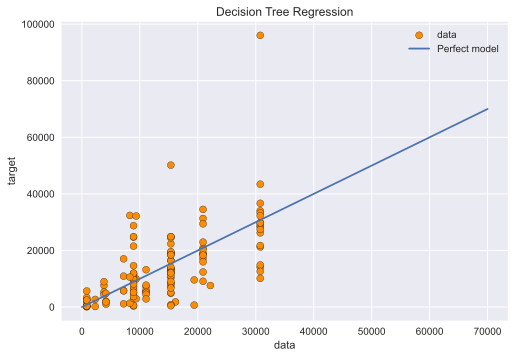

In [354]:
y_2 = DT_reg_grid.predict(X_valid)
# Plot the results
plt.figure()
plt.scatter(y_2, y_valid, edgecolor="black", c="darkorange", label="data")
x= np.arange(0, 70000)
plt.plot(x,x, label = 'Perfect model')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

This graph summarises the accuracy of the data, if the predicted y_test value and the actual y_test value are the same, the data point on the scatter graph should land on the line. Any distance above or below the line is an error. The vertical lines of points, shows the issues with using decision trees, as there are only a limited number of predicted results, that all points are assigned to. If I were to graph the less accurate base model, it would show a larger range of predicted values, as it is not limited by max depth, but the values would, on average, be further away from the accuracy line.

To look at where the Decision Tree is drawing boundaries, I will look at the "plot tree" graph. This graph shows the process through which the model categories the stations, this categorisation is why the above decision tree graph has a series of vertical lines, rather than a range.

[Text(0.5, 0.9, 'Distance from bixi center <= 4.833\nsamples = 509\nvalue = 13966.303'),
 Text(0.25, 0.7, 'Distance from bixi center <= 2.035\nsamples = 341\nvalue = 18058.006'),
 Text(0.125, 0.5, 'pop_density <= 5648.25\nsamples = 99\nvalue = 24816.323'),
 Text(0.0625, 0.3, 'points of interest prox count <= 16.0\nsamples = 21\nvalue = 12414.333'),
 Text(0.03125, 0.1, 'samples = 16\nvalue = 9364.438'),
 Text(0.09375, 0.1, 'samples = 5\nvalue = 22174.0'),
 Text(0.1875, 0.3, 'public prox count <= 0.5\nsamples = 78\nvalue = 28155.321'),
 Text(0.15625, 0.1, 'samples = 14\nvalue = 16151.071'),
 Text(0.21875, 0.1, 'samples = 64\nvalue = 30781.25'),
 Text(0.375, 0.5, 'close stations <= 0.5\nsamples = 242\nvalue = 15293.24'),
 Text(0.3125, 0.3, 'Distance from center <= 10.244\nsamples = 58\nvalue = 9455.879'),
 Text(0.28125, 0.1, 'samples = 3\nvalue = 19377.333'),
 Text(0.34375, 0.1, 'samples = 55\nvalue = 8914.709'),
 Text(0.4375, 0.3, 'Distance from bixi center <= 2.769\nsamples = 184\nvalue

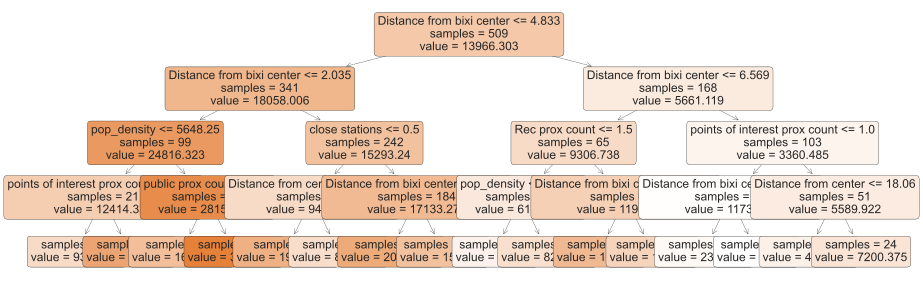

In [355]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(15,5))

plot_tree(DT_reg_grid,
          feature_names=X_train.columns,
          rounded=True,
          impurity=False,
          filled=True,
          ax=ax,
          fontsize=12)

The plot_tree, whilst messy, shows that the questions Decision Tree is asking, to predict the number of trips per station are: are there any close stations?, how close to the Bixi center is the station?, are there any points of interest?, is the population density at certain levels, as well as using the Rec prox count column. These layers are too limited to adjust for the large outliers in the dataset. To compensate for this I will look at the different columns, and see if there is normal distribution. If there is not, I will use BoxCox to try to normalise the data, before attempting to use a linear regression.

The EDA, showed that most of the data is not conducive to linear regression on its own, so I assume that there must be an issue with the normal distribution of the data, which would reduce linearity, but would not have an impact pearsonr tests (which showed correlation) or Decision Trees.

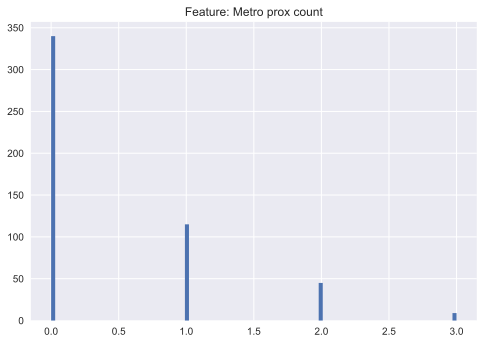

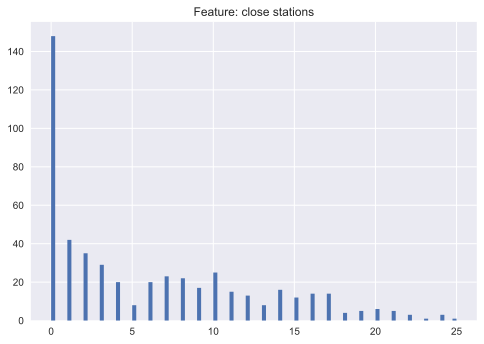

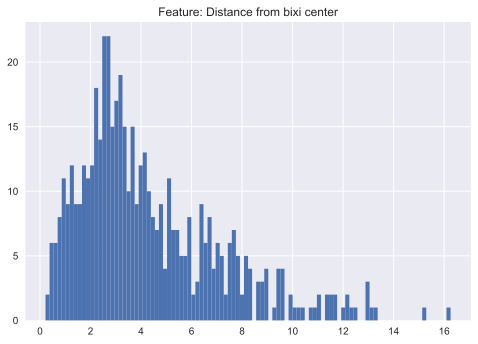

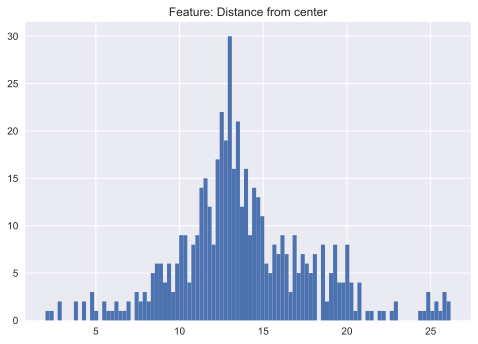

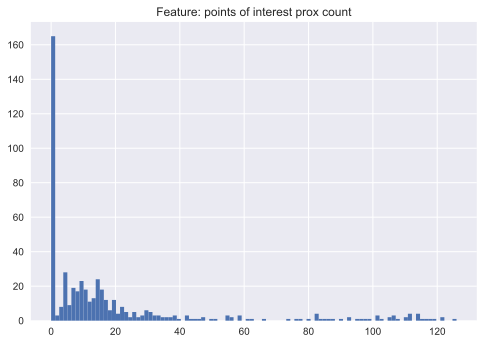

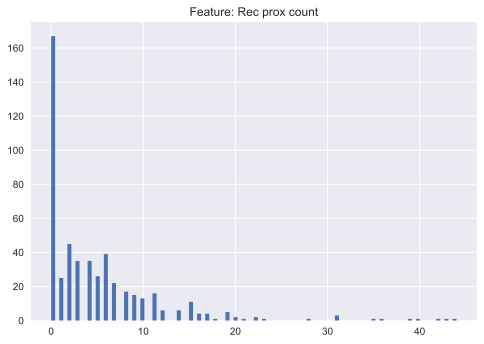

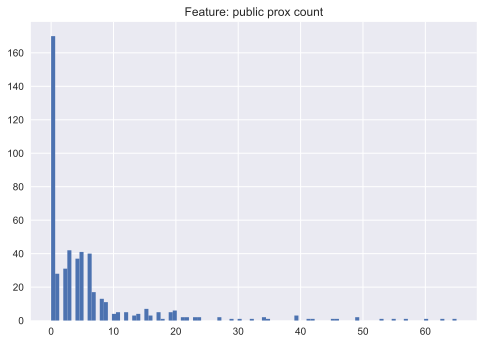

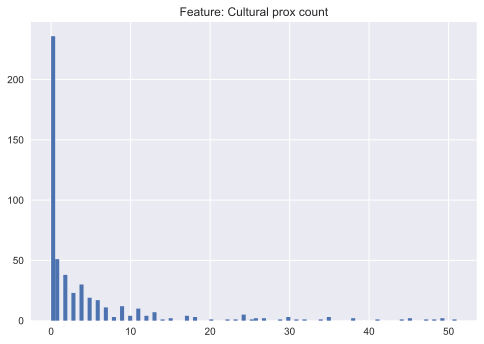

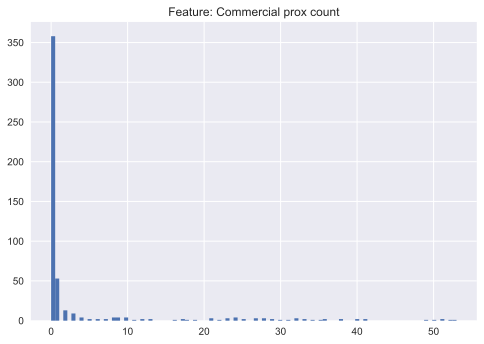

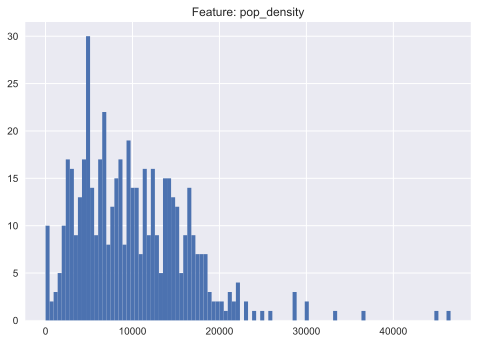

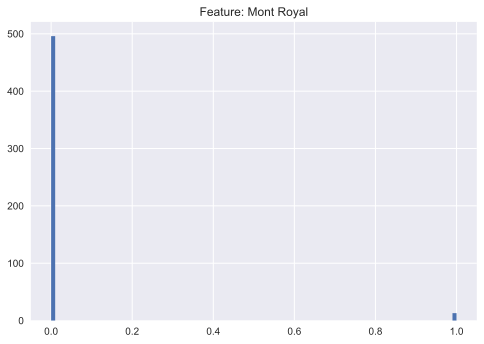

In [356]:
import ds_utils as EDA
EDA.df_hist_column_plot(X_train)

Looking at the data, I was correct in my assumption that the data is primarily expoential. To compensate for this I will run a series of BoxCox calculations on the X variables, before attempting a linear regression.

In [357]:
# +1 is added to the data, as boxcox only works on data that is larger than 0 - as a large part of my data is zero, I have had to adjust
bix_transformed_x = X +1
X_columns = bix_transformed_x.columns
bix_transformed_x['close stations'] = stats.boxcox(bix_transformed_x['close stations'])[0]
bix_transformed_x['points of interest prox count'] = stats.boxcox(bix_transformed_x['points of interest prox count'])[0]
bix_transformed_x['Rec prox count'] = stats.boxcox(bix_transformed_x['Rec prox count'])[0]
bix_transformed_x['public prox count'] = stats.boxcox(bix_transformed_x['public prox count'])[0]
bix_transformed_x['Cultural prox count'] = stats.boxcox(bix_transformed_x['Cultural prox count'])[0]
bix_transformed_x['Commercial prox count'] = stats.boxcox(bix_transformed_x['Commercial prox count'])[0]
bix_transformed_x['Metro prox count'] = stats.boxcox(bix_transformed_x['Metro prox count'])[0]


After transforming the required columns, I will repeat the X y split, to integrate the newly transformed data. I can now run a linear regression, and see how it compares to the Decision Trees, which were limited by the max_depth. In the EDA, the data did not look linear in correlation, so I doubt that the score from linear regression will be impressive, even after transforming the data.

In [358]:
X = pd.DataFrame(bix_transformed_x, columns= X_columns)
y = y

X_CV, X_test, y_CV, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_CV,y_CV, test_size=0.2, random_state=1)
X_test = pd.DataFrame(X_test)

In [359]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_CV_scaled = scaler.fit_transform(X_CV)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
estimator = [('dim_reducer', PCA()),
            ('model', LinearRegression())]
pipe = Pipeline(estimator)

param_grid = [{
    'model' : [LinearRegression()],
    'model__normalize' : [True, False],
    'dim_reducer' : [PCA(), None]
}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

fittedgrid = grid.fit(X_train_scaled, y_train)
fittedgrid.best_params_


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\ckedd\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\ckedd\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

{'dim_reducer': None,
 'model': LinearRegression(normalize=True),
 'model__normalize': True}

In [360]:
estimator = [
            ('model', LinearRegression(normalize=True, positive = True))]
pipe = Pipeline(estimator)
pipe.fit(X_train_scaled, y_train)

print(f"The model accuracy on the training data is {pipe.score(X_train_scaled, y_train)}")
print(f"The model accuracy on the validation data is {pipe.score(X_valid_scaled, y_valid)}")
print(f"The model mean absolute on the test data is {mean_absolute_error(y_valid, pipe.predict(X_valid_scaled))}")

The model accuracy on the training data is 0.2309304211751263
The model accuracy on the validation data is 0.23535279491975802
The model mean absolute on the test data is 8026.607312468412


c:\Users\ckedd\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


As expected, the results of the linear regression are extremely poor. To discover where the errors are occurring, I will use the graphing method from earlier, but using a different colour for the points, in order to distinguish between types of models. The linear regression graph shouldn't have the same vertical lines the Decision Tree had, as it is not limited in which predictions I can provide.

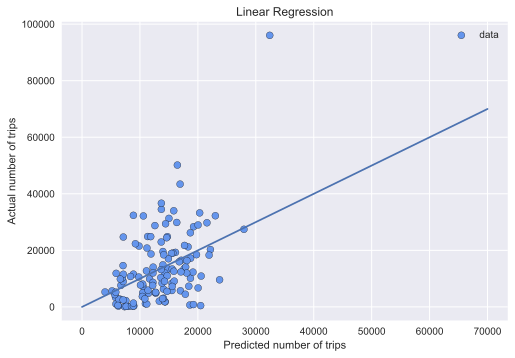

In [361]:
y_2 = pipe.predict(X_valid_scaled)
# Plot the results
plt.figure()
plt.scatter(x = y_2, y =  y_valid, edgecolor="black", c="cornflowerblue", label="data")
x= np.arange(0,70000)
plt.plot(x,x)
plt.xlabel("Predicted number of trips")
plt.ylabel("Actual number of trips")
plt.title("Linear Regression")
plt.legend()
plt.show()

The results graph for Linear Regression shows that the model is over predicting the majority of points. The reasons for this seem to be the same as I suspected in the EDA, where the outliers appear to be numerous enough to cause the the model to over-predict, whilst they are still outlier, meaning they are being  under-predicted. The column that boosts station predictions for Mont-Royal, is limited by some stations in that area having low numbers of trips. The largest prediction line produced in Decision Tree, seems to have been duplicated in the linear regression, implying that there is not enough data to model a station with more than 35,000 trips.

### Summary of initial models

| Model | variables | training accuracy | validation accuracy | Mean absolute error (validation) | summary |
|---|---|---|---|---|---|
| Decision tree base model | unset | 1.0 | -0.24 | 8830 | This was a basic Decision tree model with no adjustments, it massively overfitted as a result. |
| Decision tree Grid search model | max_depth = 3, min_leaf_samples = 5 | 0.43 | 0.31 | 7191 | The Decision tree model was run through a grid search to attempt to optimise model. The outputs massively reduced overfitting |
| Linear Regression model | normalize = True, PCA = True | 0.22 | 0.25 | 7863 | I used Box-Cox to normalize the columns, I then ran a Linear Regression and got terrible results. I think it was due to having no regularization, so I will run a Ridge regression to add L2 regularization, to see if some simplification of the model improves it. |

If the linear regression generates the most accurate predictions it can, it has to give some stations negative predicted trips, as some of the variable coefficients have to be extremely negative in order to not over-estimate most of the points. As it is impossible for a predicted station to have negative trips, I forced the model to generate positive points only. This led to the model becoming more inaccurate as negatively correlated variables had to be reduced, meaning the model predicted higher trip counts than the actual stations received. Due to the small sample size, some outlier stations have a much higher number of trips than the model predicts, but the majority are overestimated, as far more points are below the line than above it. This is why, despite normalizing the data, the linear regression model has a much lower accuracy and a much higher Mean Absolute Error than the optimised Decision Tree model.

To see if the boxcox transformation has had a major impact on the data, I will run a new optimised Decision Tree model using the new X y split. With the data now normalized, I think the model will be less liable to overfit as the impact of unscaled x-variables would be diminished.

In [362]:
from sklearn.tree import DecisionTreeRegressor
DT_reg_grid = DecisionTreeRegressor(max_depth= 4, min_samples_leaf=3, criterion='squared_error')

DT_reg_grid.fit(X_train, y_train)

print(f"The accuracy of the model on training data, with optimised parameters is {DT_reg_grid.score(X_train, y_train)}")
print(f"The accuracy of the model on validation data, with optimised parameters is {DT_reg_grid.score(X_valid, y_valid)}")
print(f"The mean absolute error of the validation data , with optimised parameters is {mean_absolute_error(y_valid,DT_reg_grid.predict(X_valid))}")

The accuracy of the model on training data, with optimised parameters is 0.5054957868780333
The accuracy of the model on validation data, with optimised parameters is 0.35558066685700473
The mean absolute error of the validation data , with optimised parameters is 6497.903326796325


The results of this model is a slight improvement in validation and training accuracy, as well as 6512.12688985436 a minor decrease in Mean Absolute Error from 6512 to 6498. This shows that normalising the X-variables had a positive impact on the models, even though decision tree shouldn't be impacted by the transformation, the accuracy still improved with the same hyper-parameters in place. Due to this improvement, I will continue to use the transformed data when producing the last models in this notebook and the advanced models in the next notebook.

To visualise any changes (although there will likely be very few), I will produce the same graph and plot_tree combination I did before and record any differences I see.

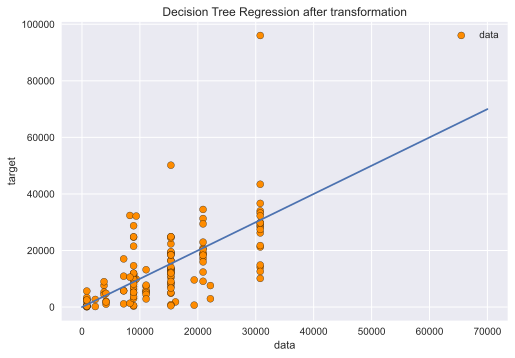

In [363]:
y_2 = DT_reg_grid.predict(X_valid)
# Plot the results
plt.figure()
plt.scatter(x = y_2, y =  y_valid, edgecolor="black", c="darkorange", label="data")
x= np.arange(0,70000)
plt.plot(x , x)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression after transformation")
plt.legend()
plt.show()

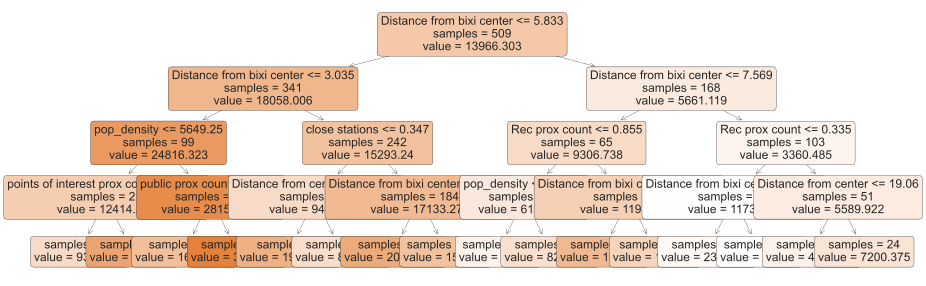

In [364]:
fig, ax = plt.subplots(figsize=(15,5))
plot_tree(DT_reg_grid,
          feature_names=X_train.columns,
          rounded=True,
          impurity=False,
          filled=True,
          ax=ax,
          fontsize=12
          )
plt.show()

The scatter plot, shows no obvious change. The accuracy and Mean Absolute Error barely improved, so aside from potentially one or two data point changes, I didn't expect to see much change in this graph.

The plot_tree above shows a couple of minor differences from the original. Firstly, one of the Point of interest prox count decision has been replaced by a public prox count decision. The second change is a Point of interest prox count has been replaced with a Rec prox count on the far right. These changes make sense, as the more granular points of interest data, is extremely skewed, so by normalising it, the data becomes far better at separating regression totals.

I will run some tests on KNN and SVM models, at the end of this page, to see which basic model is the best, before moving onto the more advanced boosting and random forest models in the "Advanced modelling" notebook.

In [365]:
from sklearn.neighbors import KNeighborsRegressor
scaler = StandardScaler()
X_CV_scaled = scaler.fit_transform(X_CV)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

estimator = [('dim_reducer', PCA()),
            ('model', KNeighborsRegressor())]
pipe = Pipeline(estimator)

param_grid = [{
    'model' : [KNeighborsRegressor()],
    'model__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'model__weights' : ['uniform', 'distance'],
    'model__algorithm' : ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'dim_reducer' : [PCA(), None]
}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

fittedgrid = grid.fit(X_train_scaled, y_train)
fittedgrid.best_params_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


{'dim_reducer': PCA(),
 'model': KNeighborsRegressor(algorithm='ball_tree', n_neighbors=14),
 'model__algorithm': 'ball_tree',
 'model__n_neighbors': 14,
 'model__weights': 'uniform'}

In [366]:
estimator = [('dim_reducer', PCA()),
            ('model', KNeighborsRegressor(algorithm='ball_tree', n_neighbors=15))]
pipe_knn= Pipeline(estimator)

pipe_knn.fit(X_train_scaled, y_train)

print(f"The accuracy of the model on training data, with optimised parameters is {pipe_knn.score(X_train_scaled, y_train)}")
print(f"The accuracy of the model on validation data, with optimised parameters is {pipe_knn.score(X_valid_scaled, y_valid)}")
print(f"The mean absolute error of the model on testing data, with optimised parameters is {mean_absolute_error(y_valid, pipe_knn.predict(X_valid_scaled))}")

The accuracy of the model on training data, with optimised parameters is 0.4201951865946605
The accuracy of the model on validation data, with optimised parameters is 0.3210106151795812
The mean absolute error of the model on testing data, with optimised parameters is 7007.315625


KNN is quite a good model, but not as accurate as Decision Tree, from the previous graphs, I believe the inaccuracy is probably due to outliers being mis-categorised, as KNN is based on how close data points are, so outliers are naturally going to be poorly predicted, even more so than in Decision Trees or Linear Regression.

To confirm my hypothesis, I will graph the KNN predictions in a scatterplot, like I have done before, but I can also use a histogram to show whether the model is over or under predicting. I am only graphing KNN with the histogram, as the linear regression was so inaccurate that it felt unnecessary to dig deeper than the scatterplot. The Decision Tree wouldn't work well with this histogram type of graph, as the decision boundaries are better shown on a scatterplot. There is not point in showing that the Decision tree is over or under predicting, if you don't know how the prediction boundaries are impacting the results. KNN works with this method, as its predictions are not easy to quantify without it.

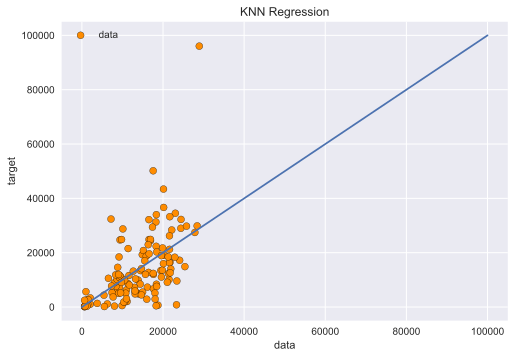

In [367]:
y_2 = pipe_knn.predict(X_valid_scaled)
# Plot the results
plt.figure()
plt.scatter(x = y_2, y =  y_valid, edgecolor="black", c="darkorange", label="data")
x= np.arange(0,100000)
plt.plot(x , x)
plt.xlabel("data")
plt.ylabel("target")
plt.title("KNN Regression")
plt.legend()
plt.show()

The KNN model appears to be fairly accurate for most of the points, with most errors occurring from stations being under-estimated at low trip counts. However, there is a clear limit to how high KNN can predict a trip count, which is due to the predictions being based on other values. Due to this limit in predictions, the outlier station is terribly predicted, causing the accuracy of the model to drop. To further visualise the errors, I will build a histogram below to show the difference

Text(0, 0.5, 'Frequency')

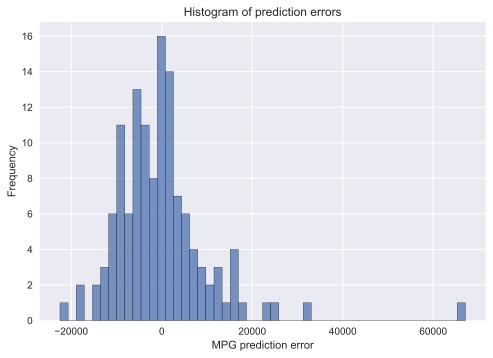

In [368]:
diff = y_valid.values - y_2
sns.histplot(diff, bins = 50)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

The histogram of errors, shows similar issues to the scatterplots. The majority of small errors are occurring negatively, with a large number of points being underpredicted by around 10,000 or less. The outliers in data really stand out with the largest outlier being predicted over 60,000 fewer trips than it actually receives. There are four other outliers with over 20,000 in prediction error, with three of them being on the under-estimated side of the graph. This graph supports my hypothesis that the outliers cause the model to over-estimate the majority of stations. This is why I believe my models all over-estimate at smaller trip count values, but under-estimate at higher trip counts.

Hopefully more advanced models will be able to adjust for this, but before I move onto more advanced models such as RandomForest, I want to run a SVR model, to confirm that Decision Trees are the best possible base model.

In [374]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
estimator = [
            ('model', SVR())]
pipe = Pipeline(estimator)

param_grid = [{
    'model' : [SVR()],
    'model__kernel' : ['poly', 'rbf', 'sigmoid'],
    'model__C' : [ 0.1, 1, 10, 100, 1000, 10000, 100000],
}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=1)

fittedgrid = grid.fit(X_train_scaled, y_train)
fittedgrid.best_params_


Fitting 5 folds for each of 21 candidates, totalling 105 fits


{'model': SVR(C=10000), 'model__C': 10000, 'model__kernel': 'rbf'}

In [375]:
SVR_reg_grid = SVR(C = 10000, kernel= 'rbf')

SVR_reg_grid.fit(X_train_scaled, y_train)

print(f"The accuracy of the model on training data, with optimised parameters is {SVR_reg_grid.score(X_train_scaled, y_train)}")
print(f"The accuracy of the model on validation data, with optimised parameters is {SVR_reg_grid.score(X_valid_scaled, y_valid)}")
print(f"The Mean Absolute Error of the model on validation data, with optimised parameters is {mean_absolute_error(y_valid,SVR_reg_grid.predict(X_valid_scaled))}")

The accuracy of the model on training data, with optimised parameters is 0.4506029891378073
The accuracy of the model on validation data, with optimised parameters is 0.32878755646739755
The Mean Absolute Error of the model on validation data, with optimised parameters is 6352.494097808107


### Final Models with Reduced Columns

| Models | variables in models | training accuracy | testing accuracy | Mean Absolute Error | summary of feedback |
|---|---|---|---|---|
| Decision Tree with transformed data | Max_depth = 3, min_leaf_sample = 4 | 0.51 | 0.36 | 6497 | Slight upgrade on the Linear Regression, and likely means the data will be suitable for a good random_forest model. |
| KNN with only poi prox | algorithm='ball_tree', n_neighbors=14 | -0.30 | -0.15 | 7007 | I wanted to see if KNN regression would generate a good response. It did not. |
| SVR model | kernel = 'rbf', C = 10,000 | 0.45 | 0.32 | 6352 |  |

In [371]:
from importlib.resources import path
from pathlib import Path  
filepath = Path('C:/Users/ckedd/Documents/Capstone data/bix_sta_prox.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
bix_sta_prox.to_csv(filepath)  